Imports

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, ConvLSTM2D, TimeDistributed, RepeatVector, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, LeakyReLU, Conv1D, MaxPooling1D,Conv1DTranspose
from tensorflow.keras import initializers
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os
import math
import glob
import scipy

from statistics import stdev

import pickle
import matplotlib.pyplot as plt

Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/MyDrive/4-2/BP Paper New/Data/Windowed_Vals/75.pkl'

with open(filename, 'rb') as f:
    train_x, train_y, max_ABP = pickle.load(f)

In [ ]:
inputs = train_x
targets = train_y

In [ ]:
train_x.shape

(105443, 250, 2)

In [ ]:
train_y.shape

(105443, 2)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.20, shuffle=True)

In [ ]:
test_y = test_y*max_ABP

CNN LSTM Model

In [ ]:
model = Sequential()

model.add(Conv1D(filters=20, kernel_size=(9), activation='relu'))
model.add(MaxPooling1D((4)))
# model.add(Dropout(0.1))
model.add(Conv1D(filters=20, kernel_size=(9), activation='relu'))
model.add(MaxPooling1D((4)))
# model.add(Dropout(0.1))
model.add(Reshape((13,20)))

model.add(Dropout(0.1))

model.add(tf.keras.layers.Bidirectional(LSTM(units=64, activation='tanh', return_sequences=True), merge_mode="concat"))
# model.add(Dropout(0.1))
model.add(LSTM(units=64, activation='tanh'))
# model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(2, activation='linear', kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.00, l2=0.001)))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, name="Adam")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer=opt, metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(train_x, train_y, validation_split=0.2, epochs=50, batch_size=200, verbose=1, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
338/338 [==============================] - 27s 28ms/step - loss: 0.0708 - mean_absolute_error: 0.0686 - val_loss: 0.0533 - val_mean_absolute_error: 0.0516 - lr: 0.0100
Epoch 2/50
338/338 [==============================] - 7s 21ms/step - loss: 0.0456 - mean_absolute_error: 0.0442 - val_loss: 0.0457 - val_mean_absolute_error: 0.0447 - lr: 0.0100
Epoch 3/50
338/338 [==============================] - 9s 25ms/step - loss: 0.0416 - mean_absolute_error: 0.0407 - val_loss: 0.0378 - val_mean_absolute_error: 0.0372 - lr: 0.0100
Epoch 4/50
338/338 [==============================] - 10s 29ms/step - loss: 0.0389 - mean_absolute_error: 0.0383 - val_loss: 0.0366 - val_mean_absolute_error: 0.0361 - lr: 0.0100
Epoch 5/50
338/338 [==============================] - 9s 27ms/step - loss: 0.0376 - mean_absolute_error: 0.0371 - val_loss: 0.0360 - val_mean_absolute_error: 0.0356 - lr: 0.0100
Epoch 6/50
338/338 [==============================] - 8s 24ms/step - loss: 0.0360 - mean_absolute_error: 0.0

Relevant Plots

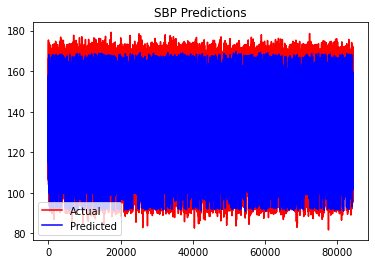

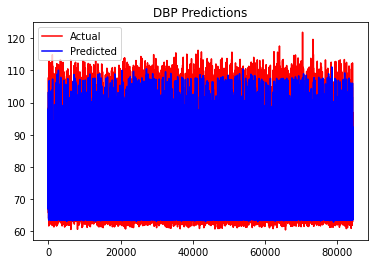

In [ ]:
train_predicted = model(train_x)

plt.plot(train_y[:,0]*max_ABP, color='r', label = 'Actual')
plt.plot(train_predicted[:,0]*max_ABP, color='b', label = 'Predicted')
plt.legend()
plt.title('SBP Predictions')

plt.show()

plt.plot(train_y[:,1]*max_ABP, color='r', label = 'Actual')
plt.plot(train_predicted[:,1]*max_ABP, color='b', label = 'Predicted')
plt.legend()
plt.title('DBP Predictions')

plt.show()

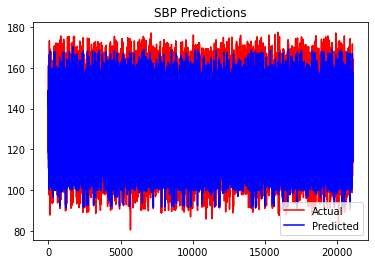

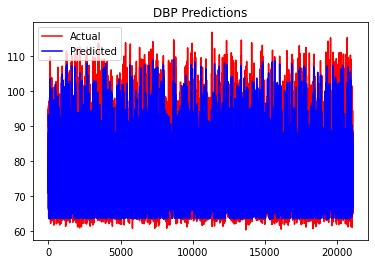

In [ ]:
test_predicted = model(test_x)

plt.plot(test_y[:,0], color='r', label = 'Actual')
plt.plot(test_predicted[:,0]*max_ABP, color='b', label = 'Predicted')
plt.legend()
plt.title('SBP Predictions')

plt.show()

plt.plot(test_y[:,1], color='r', label = 'Actual')
plt.plot(test_predicted[:,1]*max_ABP, color='b', label = 'Predicted')
plt.legend()
plt.title('DBP Predictions')

plt.show()

Testing the Model

In [ ]:
def test_dataset(test_x, test_y, model):
   
   predicted = model.predict(test_x)
   predicted = predicted*max_ABP

   predicted = pd.DataFrame(predicted, columns=['SBP', 'DBP'])
   test_y = pd.DataFrame(test_y, columns=['SBP', 'DBP'])

   mae_sbp  =   mean_absolute_error(test_y['SBP'], predicted['SBP'])
   sd_sbp =    stdev(predicted['SBP'])
   mae_dbp  =   mean_absolute_error(test_y['DBP'], predicted['DBP'])
   sd_dbp =    stdev(predicted['DBP'])
   mae_map = mean_absolute_error((test_y['SBP'] + 2*test_y['DBP'])/3, (predicted['SBP'] + 2*test_y['DBP'])/3)
   sd_map = stdev((predicted['SBP'] + 2*test_y['DBP'])/3)


   sbp_diff = np.absolute(predicted['SBP'] - test_y['SBP'])
   dbp_diff = np.absolute(predicted['DBP'] - test_y['DBP'])
   map_diff = (sbp_diff + 2*dbp_diff)/3

   #SBP
   test_sbp_5 = []
   predicted_sbp_5 = []

   test_sbp_10 = []23.7
   predicted_sbp_10 = []

   test_sbp_15 = []
   predicted_sbp_15 = []


   #DBP
   test_dbp_5 = []
   predicted_dbp_5 = []

   test_dbp_10 = []
   predicted_dbp_10 = []

   test_dbp_15 = []
   predicted_dbp_15 = []


   #MAP
   test_map_5 = []
   predicted_map_5 = []

   test_map_10 = []
   predicted_map_10 = []

   test_map_15 = []
   predicted_map_15 = []

   for i in range(len(sbp_diff)):
      #SBP
      if sbp_diff[i] <= 5:
         test_sbp_5.append(test_y['SBP'][i])
         predicted_sbp_5.append(predicted['SBP'][i])
      
      if(sbp_diff[i] <= 10):
         test_sbp_10.append(test_y['SBP'][i])
         predicted_sbp_10.append(predicted['SBP'][i])

      if(sbp_diff[i] <= 15):
         test_sbp_15.append(test_y['SBP'][i])
         predicted_sbp_15.append(predicted['SBP'][i])

      
      #DBP
      if dbp_diff[i] <= 5:
         test_dbp_5.append(test_y['DBP'][i])
         predicted_dbp_5.append(predicted['DBP'][i])
      
      if(dbp_diff[i] <= 10):
         test_dbp_10.append(test_y['DBP'][i])
         predicted_dbp_10.append(predicted['DBP'][i])

      if(dbp_diff[i] <= 15):
         test_dbp_15.append(test_y['DBP'][i])
         predicted_dbp_15.append(predicted['DBP'][i])


      #MAP
      if map_diff[i] <= 5:
         test_map_5.append((test_y['SBP'][i] + 2*test_y['DBP'][i])/3)
         predicted_map_5.append((predicted['SBP'][i] + 2*test_y['DBP'][i])/3)
      
      if(map_diff[i] <= 10):
         test_map_10.append((test_y['SBP'][i] + 2*test_y['DBP'][i])/3)
         predicted_map_10.append((predicted['SBP'][i] + 2*test_y['DBP'][i])/3)

      if(map_diff[i] <= 15):
         test_map_15.append((test_y['SBP'][i] + 2*test_y['DBP'][i])/3)
         predicted_map_15.append((predicted['SBP'][i] + 2*test_y['DBP'][i])/3)

      
   percent_sbp_5 = (len(test_sbp_5)/len(test_y['SBP'])) * 100
   percent_sbp_10 = (len(test_sbp_10)/len(test_y['SBP'])) * 100
   percent_sbp_15 = (len(test_sbp_15)/len(test_y['SBP'])) * 100

   percent_dbp_5 = (len(test_dbp_5)/len(test_y['SBP'])) * 100
   percent_dbp_10 = (len(test_dbp_10)/len(test_y['SBP'])) * 100
   percent_dbp_15 = (len(test_dbp_15)/len(test_y['SBP'])) * 100

   percent_map_5 = (len(test_map_5)/len(test_y['SBP'])) * 100
   percent_map_10 = (len(test_map_10)/len(test_y['SBP'])) * 100
   percent_map_15 = (len(test_map_15)/len(test_y['SBP'])) * 100

   return {
      'MAE SBP' : mae_sbp,
      'SD SBP' : sd_sbp,
      'MAE DBP' : mae_dbp,
      'SD DBP' : sd_dbp,
      'MAE MAP' : mae_map,
      'SD MAP' : sd_map,
      'SBP < 5' : percent_sbp_5,
      'SBP < 10' : percent_sbp_10,
      'SBP < 15' : percent_sbp_15,
      'DBP < 5' : percent_dbp_5,
      'DBP < 10' : percent_dbp_10,
      'DBP < 15' : percent_dbp_15,
      'MAP < 5' : percent_map_5,
      'MAP < 10' : percent_map_10,
      'MAP < 15' : percent_map_15,
   }



Segregating the Dataset into Hypo, Normo and Hyper tensive

In [ ]:
test_y_hypo = []
test_x_hypo = []

test_y_normo = []
test_x_normo = []

test_y_hyper = []
test_x_hyper = []

for i in range(test_y.shape[0]):
    
    if(test_y[i][0]<90 or test_y[i][1]<60):
        test_y_hypo.append([test_y[i][0],test_y[i][1]])
        test_x_hypo.append(test_x[i,:,:])
    
    elif(test_y[i][0]>140 or test_y[i][1]>90):
        test_y_hyper.append([test_y[i][0],test_y[i][1]])
        test_x_hyper.append(test_x[i,:,:])

    else:
        test_y_normo.append([test_y[i][0],test_y[i][1]])
        test_x_normo.append(test_x[i,:,:])

In [ ]:
hypo_results = test_dataset(model=model, test_x=np.array(test_x_hypo), test_y=np.array(test_y_hypo))

In [ ]:
hypo_results

{'DBP < 10': 96.15384615384616,
 'DBP < 15': 100.0,
 'DBP < 5': 76.92307692307693,
 'MAE DBP': 3.035186631871972,
 'MAE MAP': 7.906710754200744,
 'MAE SBP': 23.720132262602228,
 'MAP < 10': 65.38461538461539,
 'MAP < 15': 69.23076923076923,
 'MAP < 5': 38.46153846153847,
 'SBP < 10': 30.76923076923077,
 'SBP < 15': 42.30769230769231,
 'SBP < 5': 30.76923076923077,
 'SD DBP': 2.7801684390976535,
 'SD MAP': 8.777291696485474,
 'SD SBP': 19.830791534355512}

In [ ]:
np.array(test_x_hypo).shape

(26, 250, 2)

In [ ]:
hyper_results = test_dataset(model=model, test_x=np.array(test_x_hyper), test_y=np.array(test_y_hyper))

In [ ]:
hyper_results

{'DBP < 10': 91.73935351462288,
 'DBP < 15': 96.39815289892253,
 'DBP < 5': 76.5623396613648,
 'MAE DBP': 3.8558380779719945,
 'MAE MAP': 1.9712166378134768,
 'MAE SBP': 5.91364991344043,
 'MAP < 10': 91.65726013340173,
 'MAP < 15': 97.13699332991278,
 'MAP < 5': 69.19445869676757,
 'SBP < 10': 84.89481785531041,
 'SBP < 15': 94.41765007696254,
 'SBP < 5': 54.60236018471011,
 'SD DBP': 6.920447876369892,
 'SD MAP': 6.065503070142124,
 'SD SBP': 9.27466174548803}

In [ ]:
np.array(test_x_hyper).shape

(9745, 250, 2)

In [ ]:
normo_results = test_dataset(model=model, test_x=np.array(test_x_normo), test_y=np.array(test_y_normo))

In [ ]:
normo_results

{'DBP < 10': 96.93408729457501,
 'DBP < 15': 99.59356776815692,
 'DBP < 5': 80.98603993638453,
 'MAE DBP': 2.9882637110760886,
 'MAE MAP': 1.6247187347593985,
 'MAE SBP': 4.874156204278195,
 'MAP < 10': 95.29952288390176,
 'MAP < 15': 99.06343877010072,
 'MAP < 5': 76.51528538611062,
 'SBP < 10': 88.33716204276374,
 'SBP < 15': 94.37179713730342,
 'SBP < 5': 67.65329563527125,
 'SD DBP': 5.649720617202932,
 'SD MAP': 6.229082059419976,
 'SD SBP': 11.057476498392377}